In [21]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# fetch dataset 
data = pd.read_csv("dataR2.csv")
  
# data (as pandas dataframes) 
X = data.drop(columns='Classification')
y = data['Classification'].map({2: 0, 1: 1}) # Map 2 to 0 and 1 to 1, 0 = pacient healthy, 1 = pacient sick
  
print("Dataset shape:", data.shape)
print(data.head())

Dataset shape: (116, 10)
   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   

     MCP.1  Classification  
0  417.114               1  
1  468.786               1  
2  554.697               1  
3  928.220               1  
4  773.920               1  


# K-NN classifier 

### 1) No curse of dimention 

In [24]:
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])

Number of samples: 116
Number of features: 9


Then d is small enough to insure that we are not in the curse of dimention

### 2) train-test split and rescaling of the feature 

Feature scaling is important for k-NN, as it is a distance-based algorithm and is sensitive to the scale of the features. This means that if some data are much farther from others due to unscaled features, it can damage the quality of the predictions.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # train/test split with 70% training and 30% testing


# Feature scaling
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

### 3) Cross validation to find the best k nearest neighbor

In [35]:
k_scores = []
K_list = np.arange(1, X.shape[0] // 4 )  # concidering 1/4 of the samples as neaighbors is large enough for k-NN to don't overfit


for k in K_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='f1')
    k_scores.append(score.mean())

k_scores = np.array(k_scores)

k_optimal = K_list[np.argmax(k_scores)]
print("The best k for k-NN is k =", k_optimal)

The best k for k-NN is k = 5


### 4) Model performance 

Accuracy: 0.8
F1 Score: 0.798014888337469
Recall: 0.7058823529411765
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.86      0.71      0.77        17

    accuracy                           0.80        35
   macro avg       0.81      0.80      0.80        35
weighted avg       0.81      0.80      0.80        35



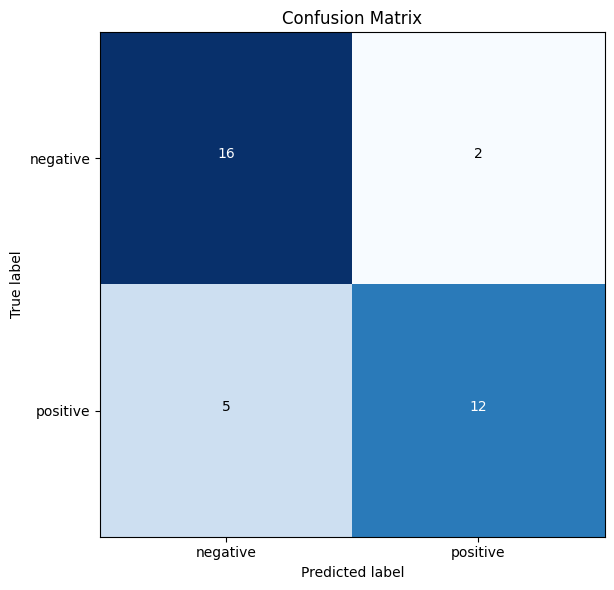

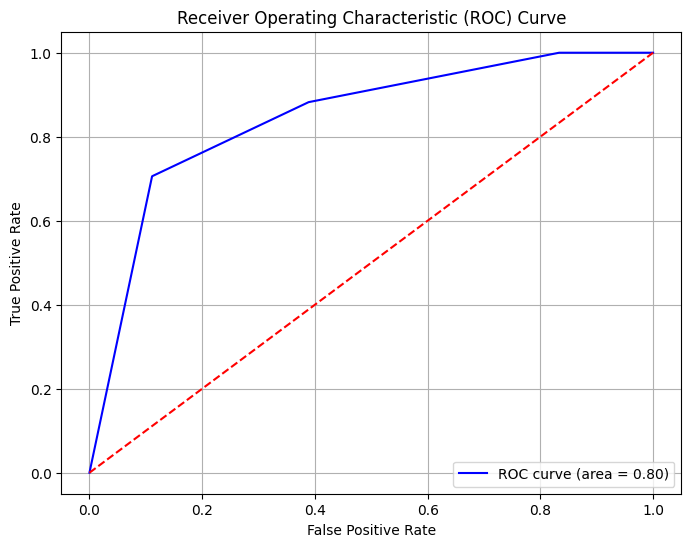

In [36]:

knn = KNeighborsClassifier(n_neighbors=k_optimal) # using the best k founded earlier
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display differents performance of the model
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Recall:", rec)
print("Classification Report:\n", class_report)

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.xticks(np.arange(len(np.unique(y))),labels = ["negative", "positive"])
plt.yticks(np.arange(len(np.unique(y))),labels = ["negative", "positive"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Plotting ROC curve
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(f1))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()